In [9]:
%run Financial_Agent_Self_Eval.ipynb

In [10]:
model = update_router()

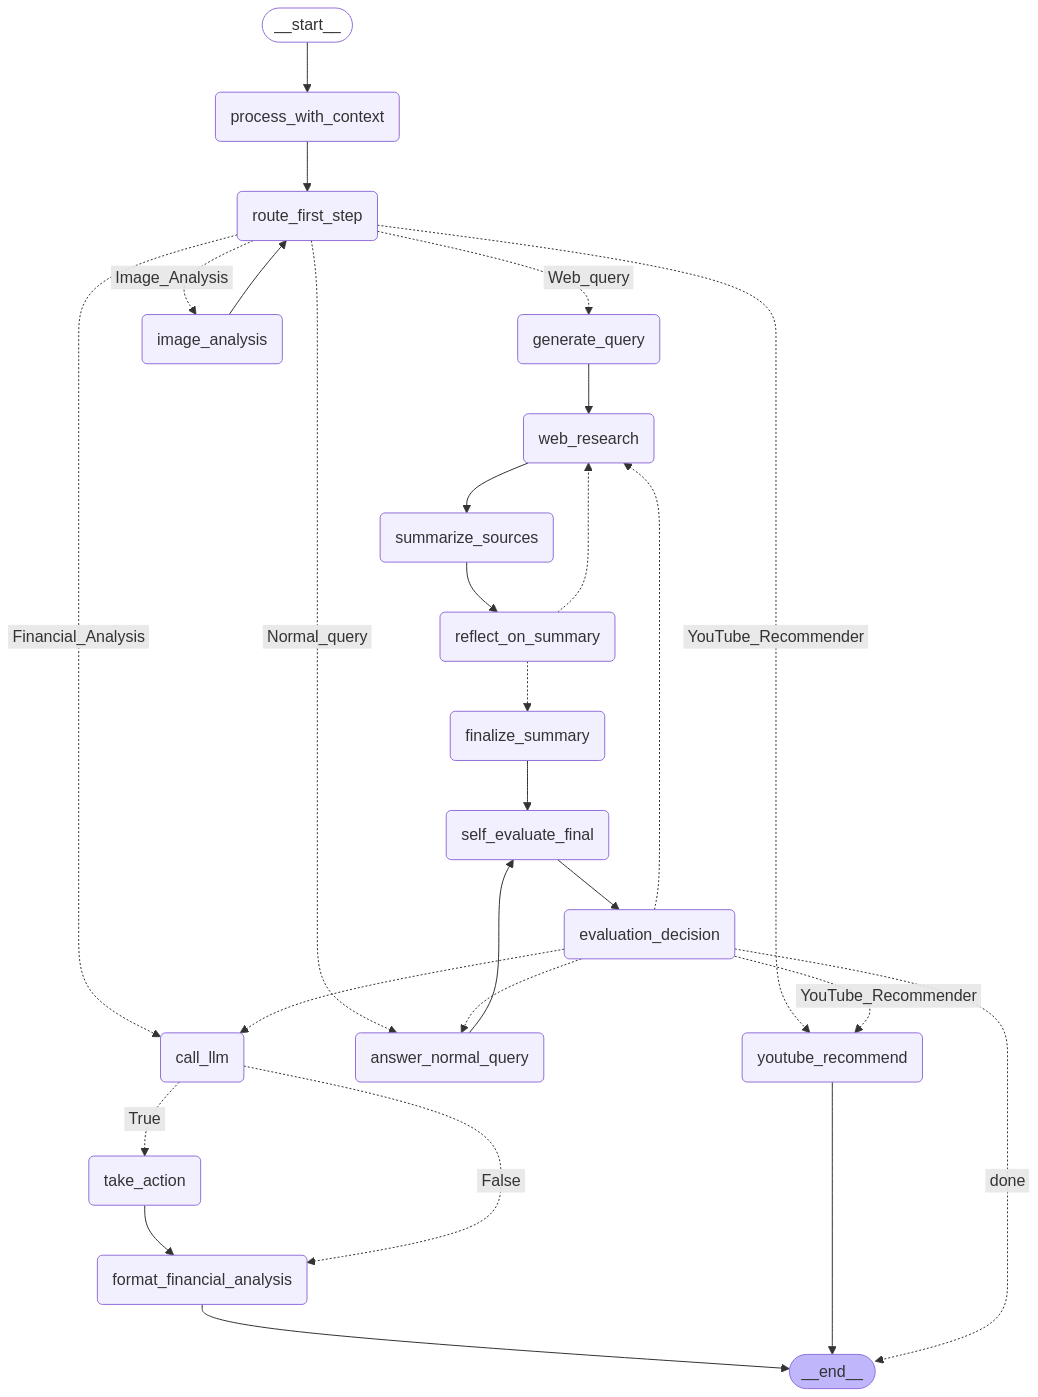

In [11]:
model

In [12]:
class FinancialChatBot:
    def __init__(self):
        self.conversation_history = []
        self.model = update_router()
        
    def _format_bot_message(self, content: str) -> str:
        """Format the bot's message for display"""
        return f"🤖 Assistant: {content}"
    
    def _format_user_message(self, content: str) -> str:
        """Format the user's message for display"""
        return f"👤 User: {content}"
    
    def chat(self, user_input: str, image_path: str = None) -> str:
        """
        Process a single chat interaction
        
        Args:
            user_input (str): The user's message
            image_path (str, optional): Path to an image if one is provided
            
        Returns:
            str: The bot's response
        """
        # Add user message to history
        self.conversation_history.append(self._format_user_message(user_input))
        
        # Create initial state with image if provided
        image_list = [image_path] if image_path else []
        initial_state = create_initial_state(user_input, image_list)
        
        try:
            # Process through the model
            response = self.model.invoke(initial_state)
            
            # Extract the response from running_summary
            bot_response = response.get('running_summary', '')
            if not bot_response and response.get('messages'):
                # Fallback to last message content if running_summary is empty
                bot_response = response['messages'][-1].content
                
            # Format and store bot's response
            formatted_response = self._format_bot_message(bot_response)
            self.conversation_history.append(formatted_response)
            
            return bot_response
            
        except Exception as e:
            error_message = f"I apologize, but I encountered an error: {str(e)}"
            self.conversation_history.append(self._format_bot_message(error_message))
            return error_message
    
    def get_conversation_history(self) -> str:
        """Return the full conversation history"""
        return "\n\n".join(self.conversation_history)
    
    def clear_history(self):
        """Clear the conversation history"""
        self.conversation_history = []



In [13]:
class FinancialChatBot:
    def __init__(self):
        self.conversation_history = []
        self.model = update_router()
        self.context_messages = []  # Store actual message objects for context
        
    def _format_bot_message(self, content: str) -> str:
        """Format the bot's message for display"""
        return f"🤖 Assistant: {content}"
    
    def _format_user_message(self, content: str) -> str:
        """Format the user's message for display"""
        return f"👤 User: {content}"
    
    def _update_context(self, user_input: str, bot_response: str):
        """Update the context messages for the next interaction"""
        from langchain_core.messages import HumanMessage, AIMessage
        
        # Add to context messages (for model processing)
        self.context_messages.append(HumanMessage(content=user_input))
        self.context_messages.append(AIMessage(content=bot_response))
        
        # Keep context within a reasonable size (last 5 interactions = 10 messages)
        if len(self.context_messages) > 10:
            self.context_messages = self.context_messages[-10:]
    
    def _process_with_context(self, user_input: str):
        """Generate a contextualized query based on conversation history"""
        from langchain_core.messages import SystemMessage
        
        if not self.context_messages:
            return user_input
        
        # Create a prompt to contextualize the query
        context_system_prompt = """
        You are a financial assistant analyzing a conversation history.
        Given the conversation history and a new user query, your task is to:
        1. Understand the context of the ongoing conversation
        2. Generate an enhanced version of the user's query that incorporates relevant context
        3. Return ONLY the enhanced query without any explanations
        """
        
        # Create a formatted context
        context_prompt = "Conversation history:\n"
        for msg in self.context_messages[-6:]:  # Use last 3 interactions max
            role = "User" if isinstance(msg, HumanMessage) else "Assistant"
            context_prompt += f"{role}: {msg.content}\n\n"
        
        context_prompt += f"New user query: {user_input}\n\nGenerate an enhanced query that incorporates context:"
        
        # Use LLM to generate contextualized query
        try:
            messages = [
                SystemMessage(content=context_system_prompt),
                HumanMessage(content=context_prompt)
            ]
            enhanced_query = llm.invoke(messages).content.strip()
            return enhanced_query
        except Exception as e:
            print(f"Context processing error: {e}")
            return user_input  # Fallback to original query
    
    def chat(self, user_input: str, image_path: str = None) -> str:
        """
        Process a single chat interaction with context awareness
        
        Args:
            user_input (str): The user's message
            image_path (str, optional): Path to an image if one is provided
            
        Returns:
            str: The bot's response
        """
        # Add user message to display history
        self.conversation_history.append(self._format_user_message(user_input))
        
        # Skip contextualizing if this is the first message or providing an image
        contextualized_input = user_input
        if self.context_messages and not image_path:
            contextualized_input = self._process_with_context(user_input)
            # For debugging
            # print(f"Original: {user_input}\nEnhanced: {contextualized_input}")
        
        # Create initial state with image if provided
        image_list = [image_path] if image_path else []
        initial_state = create_initial_state(contextualized_input, image_list)
        
        # Add all previous messages to the state
        if self.context_messages:
            initial_state["messages"] = self.context_messages + [HumanMessage(content=contextualized_input)]
        
        try:
            # Process through the model
            response = self.model.invoke(initial_state)
            
            # Extract the response from running_summary
            bot_response = response.get('running_summary', '')
            if not bot_response and response.get('messages'):
                # Fallback to last message content if running_summary is empty
                bot_response = response['messages'][-1].content
                
            # Update context with this interaction
            self._update_context(user_input, bot_response)
                
            # Format and store bot's response for display
            formatted_response = self._format_bot_message(bot_response)
            self.conversation_history.append(formatted_response)
            
            return bot_response
            
        except Exception as e:
            error_message = f"I apologize, but I encountered an error: {str(e)}"
            self.conversation_history.append(self._format_bot_message(error_message))
            return error_message
    
    def get_conversation_history(self) -> str:
        """Return the full conversation history"""
        return "\n\n".join(self.conversation_history)
    
    def clear_history(self):
        """Clear the conversation history"""
        self.conversation_history = []
        self.context_messages = []

In [14]:
import os
from openai import OpenAI

url = 'https://api.two.ai/v2';

client = OpenAI(base_url=url,
                api_key=os.environ.get("SUTRA_API_KEY"))

In [15]:
language = 'hindi'

In [20]:
def main():
    # Initialize the chatbot
    chatbot = FinancialChatBot()
    
    print("Welcome to the Financial Assistant! (Type 'quit' to exit)")
    print("You can also share images by typing 'image: ' followed by the image path")
    
    while True:
        user_input = input("\n👤 You: ").strip()
        
        if user_input.lower() == 'quit':
            print("\nGoodbye! Thank you for using the Financial Assistant.")
            break
            
        # Check if user is sharing an image
        image_path = None
        if user_input.startswith('image:'):
            image_path = user_input[6:].strip()
            user_input = "What do you see in this image?"
        
        # Get bot's response
        response = chatbot.chat(user_input, image_path)
        
        stream = client.chat.completions.create(model='sutra-v2',
                                                messages = [{"role": "user", "content": "Translate this text in" + language + ": " + response}],
                                                max_tokens=1024,
                                                temperature=0,
                                                stream=True)

        print("\n🤖 Assistant:\n",)
        for chunk in stream:
            if len(chunk.choices) > 0:
                content = chunk.choices[0].delta.content
                finish_reason = chunk.choices[0].finish_reason
                if content and finish_reason is None:
                    print(content, end='', flush=True)
        
        # Print the response

In [21]:
if __name__ == "__main__":
    main()

Welcome to the Financial Assistant! (Type 'quit' to exit)
You can also share images by typing 'image: ' followed by the image path

🤖 Assistant:

## सामान्य प्रश्न उत्तर

**स्टॉक**

स्टॉक, जिसे इक्विटी भी कहा जाता है, एक सार्वजनिक रूप से व्यापार की जाने वाली कंपनी में स्वामित्व का एक हिस्सा दर्शाता है।

जब आप एक स्टॉक खरीदते हैं, तो आप एक शेयरधारक बन जाते हैं, जिसका अर्थ है कि आप उस कंपनी का एक छोटा सा हिस्सा रखते हैं।

शेयरधारकों को कुछ कंपनी मामलों पर वोट देने का अधिकार होता है और कंपनी के लाभ का एक हिस्सा लाभांश के रूप में प्राप्त करने का अधिकार होता है। स्टॉक का मूल्य स्टॉक मार्केट में आपूर्ति और मांग के आधार पर बदलता रहता है।
🤖 Assistant:

## वेब अनुसंधान सारांश

एप्पल के शेयरों में वर्ष की शुरुआत से लगभग 15% की महत्वपूर्ण गिरावट आई है, जो $222.64 के निम्न स्तर पर पहुंच गया है। इस गिरावट के बावजूद, वेडबश के विश्लेषक डैनियल आइव्स एप्पल के भविष्य के प्रति आशावादी बने हुए हैं, 2025 में शेयरों के लिए नए उच्च स्तर की भविष्यवाणी कर रहे हैं। वे वर्तमान मंदी की भावना को प्रमुख एआई सुविधाओ